In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
results_df = pd.read_csv('data/13_estimation_results/Sumatra_multiple_models_cross_validation_results_sorted.csv')
len(results_df)

1496

In [4]:
summary_stats = results_df[['r2_score', 'rmse', 'pearson_r']].describe()
summary_stats

,r2_score,rmse,pearson_r
count,1.496000e+03,1.496000e+03,1496.000000
mean,-9.048390e+22,1.642448e+11,0.375754
std,3.486806e+24,5.523242e+12,0.253651
min,-1.348633e+26,3.115526e+00,-0.925825
25%,-4.274265e-01,1.034866e+01,0.251369
50%,1.453568e-02,1.305922e+01,0.396203
75%,2.152264e-01,1.773898e+01,0.531289
max,8.745623e-01,2.128056e+14,0.943669


In [5]:
# Performance by model type
model_performance = results_df.groupby('estimator_name')[['r2_score', 'rmse', 'pearson_r']].mean()
model_performance

,r2_score,rmse,pearson_r
estimator_name,,,
GradientBoostingRegressor,-2.333265e-01,1.432937e+01,0.427570
LinearRegression,-3.619356e+23,6.569793e+11,0.337728
RandomForestRegressor,-2.792200e-01,1.427939e+01,0.439731
Sequential,-5.156199e+00,2.306545e+01,0.297987


In [6]:
# Analyze performance by split type
split_performance = results_df.groupby('validation')[['r2_score', 'rmse', 'pearson_r']].mean()
split_performance


,r2_score,rmse,pearson_r
validation,,,
cross validation id,-2.697265e+23,4.256112e+11,0.360051
cross validation month,9.431480e-02,1.300460e+01,0.481370
cross validation year,-1.043005e+21,6.855134e+10,0.278574


In [12]:
# Calculating mean R2 and RMSE for each PHU
phu_split_performance = results_df.groupby(['phu_id', 'validation']).agg({
    'r2_score': 'mean',
    'rmse': 'mean',
    'no_obs': 'sum'  # Total number of observations for each PHU
}).reset_index()
# Sort by R2 score
phu_split_performance.sort_values(by='r2_score', ascending=False, inplace=True)
# don't show the exponential notation
pd.options.display.float_format = '{:.4f}'.format
phu_split_performance.head()

phu_split_performance.head(5)["phu_id"].unique()
# phu_split_performance

array([149., 152., 120., 119., 188.])

## Train the model

In [14]:
from gee_scripts.parameters import explain_vars
from gee_scripts.models import get_random_forest, get_regressors
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error
from gee_scripts.plots import plot_observed_vs_predicted

import seaborn as sns


In [15]:
df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])
len(df)

31547

In [16]:
data = df[df.phu_id.isin([297.0, 351.0, 352.0, 256.0, 340.0])]
len(data)

17010

In [17]:
data.shape[1]

50

/tmp/ipykernel_150418/831175479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df['Target'] = data["gwl_cm"]


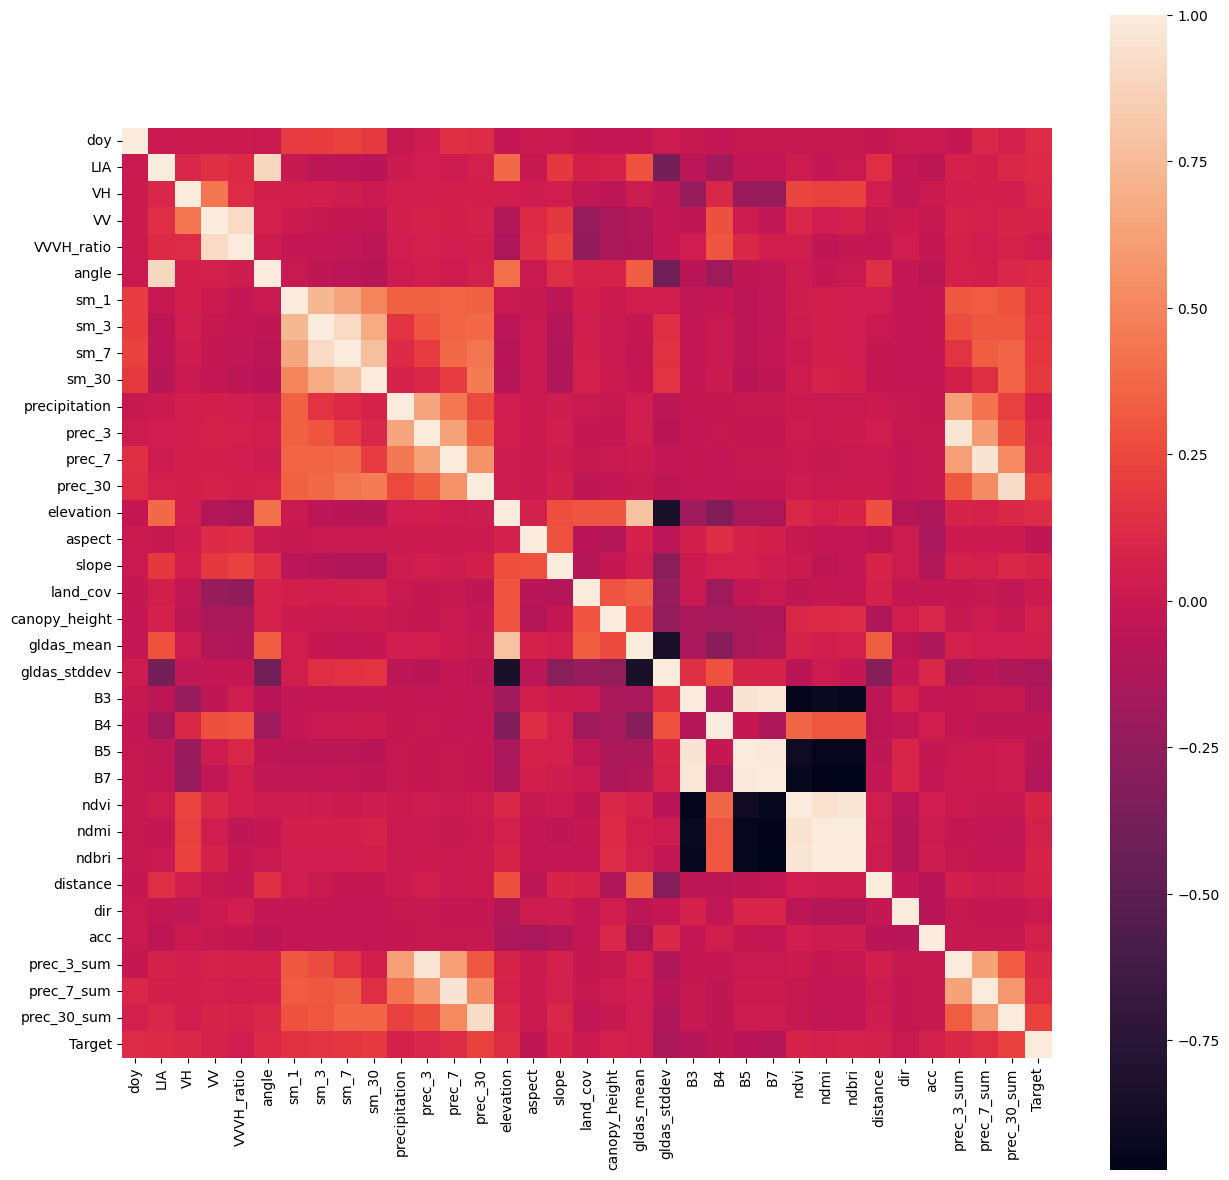

In [18]:
corr_df = data[explain_vars]
corr_df['Target'] = data["gwl_cm"]

C_mat = corr_df.corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, square = True)
plt.show()

lenght of train and test 12863 4147
r2_score: 0.39975588470003354
rmse: 11.805383467214861
pearson r: 0.633272699323606
p-value: 0.0


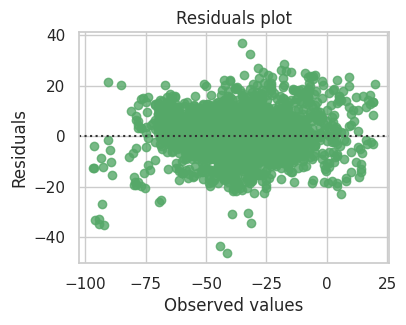

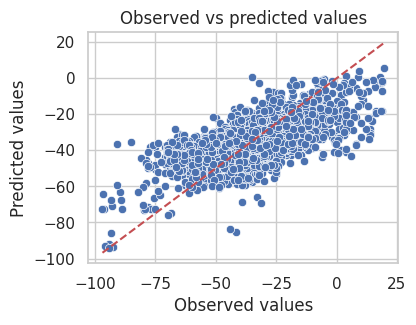

In [21]:
# PCA TEST
# Divide train and test by PCA and year
# train_data = data[data["date"].dt.year.isin([2020,2021,2022])]
# test_data = data[data["date"].dt.year.isin([2023])]

# # Divide train and test by PCA and month


train_data = data[data["date"].dt.month.isin([1,2,4,5,7,8,10,11,12])]
test_data = data[data["date"].dt.month.isin([3,6,9,])]

X_train, X_test = train_data[explain_vars], test_data[explain_vars]
y_train, y_test = train_data["gwl_cm"], test_data["gwl_cm"]

print("lenght of train and test", len(X_train), len(X_test))

####################### TRAIN

regr = get_random_forest()

regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)

r, p = pearsonr(y_test, y_pred_test)
r2_score_val = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print all the metrics
print(f"r2_score: {r2_score_val}")
print(f"rmse: {rmse}")
print(f"pearson r: {r}")
print(f"p-value: {p}")

plot_observed_vs_predicted(y_test, y_pred_test, "Observed vs Predicted GWL")


In [23]:
from gee_scripts.models import bootstrap

In [24]:
bootrap_result = bootstrap(data, "gwl_cm", 100, 0.8, explain_vars)
bootrap_result

Training with 17010 observations


,mean,min,max,median
r,0.7942,0.7750,0.8151,0.7933
r2,0.6204,0.5945,0.6485,0.6190
rmse,9.3212,8.9666,9.6583,9.3187
samples_train,13608.0000,13608.0000,13608.0000,NaN
samples_test,3402.0000,3402.0000,3402.0000,NaN
